# Sesión 1 — Puente: de Conceptos a Código (ML con Python / PyTorch)

**Instructor:** Cesar Garcia  

Esta sesión conecta el **curso conceptual de Machine Learning** (pérdida, gradientes, optimización, generalización)
con **código real en PyTorch**.

El objetivo no es memorizar APIs, sino **entender cómo se ve el aprendizaje en código**.

---
## Mapa mental del entrenamiento (recordatorio)

1. **Forward** — predicción  
2. **Loss** — medición del error  
3. **Backward** — cálculo del gradiente  
4. **Step** — actualización de parámetros  
5. Repetir (batches y épocas)

En esta notebook verás este ciclo **literalmente implementado**.


## Concepto → objeto en PyTorch

| Concepto | En PyTorch |
|---|---|
| Datos $(x, y)$ | `Dataset`, `DataLoader` |
| Modelo | `nn.Module` |
| Forward | `model(x)` |
| Función de pérdida | `nn.MSELoss`, `nn.CrossEntropyLoss` |
| Gradiente | `loss.backward()` |
| Optimización | `torch.optim` |
| Learning rate | `lr` |
| Batch / iteración | `for xb, yb in loader:` |
| Época | `for epoch in range(E):` |
| Regularización | `weight_decay`, `Dropout` |
| Evaluación | `model.eval()`, `torch.no_grad()` |


**Idea clave:**  
NumPy calcula números.  
PyTorch calcula números **y cómo cambian esos números**.


In [2]:
# Verificar disponibilidad de PyTorch (Colab usualmente ya lo incluye)

import importlib, sys, subprocess

def asegurar_torch():
    spec = importlib.util.find_spec("torch")
    if spec is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "torch", "torchvision", "torchaudio"])
    else:
        print("PyTorch ya está instalado.")

asegurar_torch()

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

print("versión de torch:", torch.__version__)


PyTorch ya está instalado.
versión de torch: 2.9.1+cu128


## Dataset sintético (clasificación binaria)

Usamos un dataset pequeño para concentrarnos en el **ciclo de entrenamiento**, no en ingeniería de datos.


In [3]:
torch.manual_seed(0)

N = 400
x0 = torch.randn(N//2, 2) + torch.tensor([-2.0, 0.0])
x1 = torch.randn(N//2, 2) + torch.tensor([ 2.0, 0.0])

X = torch.cat([x0, x1], dim=0)
y = torch.cat([torch.zeros(N//2), torch.ones(N//2)]).long()

ds = TensorDataset(X, y)
train_loader = DataLoader(ds, batch_size=32, shuffle=True)

X.shape, y.shape


(torch.Size([400, 2]), torch.Size([400]))

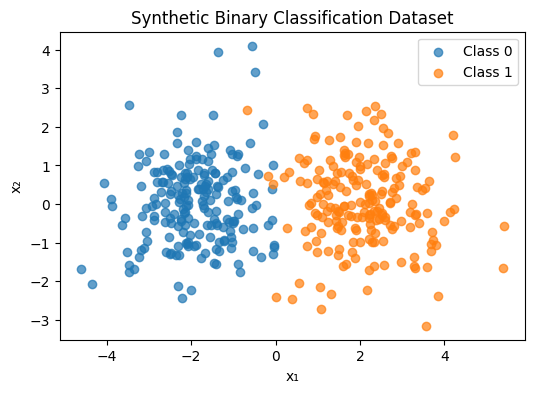

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

plt.scatter(x0[:, 0], x0[:, 1], label="Class 0", alpha=0.7)
plt.scatter(x1[:, 0], x1[:, 1], label="Class 1", alpha=0.7)

plt.xlabel("x₁")
plt.ylabel("x₂")
plt.legend()
plt.title("Synthetic Binary Classification Dataset")
plt.show()


## Red neuronal mínima (MLP)

**Correspondencia conceptual:**
- Capas lineales → multiplicación matricial + sesgo
- ReLU → no linealidad
- Salida → *logits* (para clasificación)

No confundir *logits* con logits de probabilidad: $\ln{\frac{p}{1-p}}$


In [5]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )

    def forward(self, x):
        return self.net(x)

model = MLP()
model


MLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=2, bias=True)
  )
)

## Función de pérdida y optimizador

- Pérdida: `CrossEntropyLoss` (espera *logits*, no softmax)
- Optimizador: `Adam`


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

criterion, optimizer


(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     decoupled_weight_decay: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     weight_decay: 0
 ))

In [9]:
for param in model.parameters():
    print(param.shape)

torch.Size([16, 2])
torch.Size([16])
torch.Size([2, 16])
torch.Size([2])


## Training loop — el puente completo

Aquí aparece el ciclo de aprendizaje completo visto en el curso conceptual.


In [ ]:
E = 30
for epoch in range(E):
    model.train()
    total_loss = 0.0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)      # forward
        loss = criterion(logits, yb)
        loss.backward()         # backward
        optimizer.step()        # actualización
        total_loss += loss.item()

    if (epoch + 1) % 5 == 0:
        print(f"época {epoch+1:02d} | pérdida {total_loss/len(train_loader):.4f}")


/tmp/ipykernel_16542/1495422181.py:12: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  print(logits.grad())


TypeError: 'NoneType' object is not callable

## Evaluación mínima

Esta evaluación usa los mismos datos de entrenamiento (optimista por diseño).
La separación train/validación se verá en las siguientes sesiones.


In [8]:
loss.grad()

/tmp/ipykernel_16542/3477576285.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  loss.grad()


TypeError: 'NoneType' object is not callable

In [ ]:
model.eval()
with torch.no_grad():
    logits = model(X)
    pred = logits.argmax(dim=1)
    acc = (pred == y).float().mean().item()

acc


## Orientación: arreglos NumPy vs tensores PyTorch

Una pregunta común es:

> *“¿PyTorch es solo NumPy con otra sintaxis?”*

**No.** La diferencia clave es la **diferenciación automática**.

### Comparación conceptual

| Característica | NumPy | PyTorch |
|---|---|---|
| Objetivo principal | Cálculo numérico | Cálculo diferenciable |
| Objeto central | `ndarray` | `Tensor` |
| Gradientes | ❌ | ✅ |
| Backpropagation | ❌ | ✅ |
| Soporte GPU | ❌ | ✅ |
| Entrenamiento ML | ❌ | ✅ |

PyTorch existe porque **el aprendizaje automático necesita gradientes**.


In [ ]:
# Ilustración mínima: por qué existe PyTorch

import numpy as np
import torch

# Arreglo NumPy
x_np = np.array([1.0, 2.0, 3.0])
print("Suma NumPy:", x_np.sum())

# Tensor PyTorch con seguimiento de gradientes
x_t = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
y_t = x_t.sum()
y_t.backward()

print("Suma PyTorch:", y_t.item())
print("Gradiente:", x_t.grad)
